In [1]:
import numpy as np
npz = np.load('/home/e19b516g/yejing/data/data_for_graph/npz/val/form_5_648_E3236.npz')

In [3]:
print(npz['edge_labels'])

[[0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [8. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 8. 0. 2. 2. 0. 0. 0. 0. 0.]
 [0. 0. 8. 0. 1. 2. 2. 2. 0. 0.]
 [0. 0. 8. 1. 0. 2. 2. 2. 0. 0.]
 [0. 0. 0. 8. 8. 0. 1. 1. 2. 2.]
 [0. 0. 0. 8. 8. 1. 0. 1. 2. 2.]
 [0. 0. 0. 8. 8. 1. 1. 0. 2. 2.]
 [0. 0. 0. 0. 0. 8. 8. 8. 0. 1.]
 [0. 0. 0. 0. 0. 8. 8. 8. 1. 0.]]


In [6]:
import torch
a = torch.tensor([[0,1],[1,0]])
# fill the diagonal with 1
a.fill_diagonal_(1)

tensor([[1, 1],
        [1, 1]])

In [2]:
print(npz['strokes_emb'].shape)

(10, 100, 2)


In [3]:
print(npz['stroke_labels'].shape)

(10,)


In [6]:
import torch
nn = torch.empty(0, 100, 2)

In [8]:
emb = torch.ones(10,100,2)
nn = torch.cat((nn, emb), 0)

In [11]:
nn = torch.cat((nn, torch.zeros(3,100,2)), 0)

In [12]:
nn.shape

torch.Size([13, 100, 2])

In [16]:
y = torch.load('/home/e19b516g/yejing/data/data_for_graph/S100_R5_Speed_False/val_y.pt')
X = torch.load('/home/e19b516g/yejing/data/data_for_graph/S100_R5_Speed_False/val_X.pt')

In [17]:
print(y.shape)
print(X.shape)

torch.Size([24406])
torch.Size([24406, 100, 2])


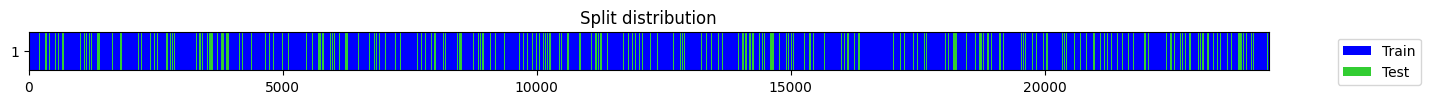

In [19]:
from tsai.all import *
s = get_splits(y, valid_size=0.2, random_state=42)

In [34]:
s

((#19525) [5164,10121,18887,8800,17783,12934,15168,16906,11471,4815...],
 (#4881) [14517,14602,24129,7720,22173,7705,20993,17632,332,15593...])

In [38]:
# create tuple sss[1] 0~100, sss[2] 101~200
sss = (list(range(0,12)), list(range(12,20)))

In [39]:
sss

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17, 18, 19])

In [2]:
import torch

ckpt = torch.load('/home/e19b516g/yejing/code/Edge_GAT/pretrain_logs/S100_R5_Speed_False_lr_0.001/version_1/checkpoints/epoch=22-step=120037.ckpt',map_location=torch.device('cpu'))

In [13]:
from Model.LitModel import LitModel
model = LitModel(
    node_input_size = 100,
    edge_input_size = 20,
    gat_input_size = 128,
    gat_hidden_size = 64,
    gat_output_size = 128,
    gat_n_heads = 8,
    node_class_nb = 114,
    edge_class_nb = 14,
    dropout = 0.6,
    lambda1 = 0.5,
    lambda2 =  0.5,
    lr = 1e-3,
    device = 'cpu'
)
# model.load_state_dict(ckpt, strict=False)

node_emb {'Total': 429620, 'Trainable': 429620}
edge_emb {'Total': 2688, 'Trainable': 2688}
gat1 {'Total': 8208, 'Trainable': 8208}
gat2 {'Total': 8448, 'Trainable': 8448}
readout_node {'Total': 14706, 'Trainable': 14706}
readout_edge {'Total': 1806, 'Trainable': 1806}


In [20]:
model.load_state_dict(ckpt, strict=False)

_IncompatibleKeys(missing_keys=['model.node_emb.block.xception.0.bottleneck.weight', 'model.node_emb.block.xception.0.convs.0.depthwise_conv.weight', 'model.node_emb.block.xception.0.convs.0.pointwise_conv.weight', 'model.node_emb.block.xception.0.convs.1.depthwise_conv.weight', 'model.node_emb.block.xception.0.convs.1.pointwise_conv.weight', 'model.node_emb.block.xception.0.convs.2.depthwise_conv.weight', 'model.node_emb.block.xception.0.convs.2.pointwise_conv.weight', 'model.node_emb.block.xception.0.maxconvpool.1.weight', 'model.node_emb.block.xception.1.bottleneck.weight', 'model.node_emb.block.xception.1.convs.0.depthwise_conv.weight', 'model.node_emb.block.xception.1.convs.0.pointwise_conv.weight', 'model.node_emb.block.xception.1.convs.1.depthwise_conv.weight', 'model.node_emb.block.xception.1.convs.1.pointwise_conv.weight', 'model.node_emb.block.xception.1.convs.2.depthwise_conv.weight', 'model.node_emb.block.xception.1.convs.2.pointwise_conv.weight', 'model.node_emb.block.xcep

In [34]:

for name, param in model.named_parameters():
    print(name, param.shape)

model.node_emb.block.xception.0.bottleneck.weight torch.Size([16, 100, 1])
model.node_emb.block.xception.0.convs.0.depthwise_conv.weight torch.Size([16, 1, 39])
model.node_emb.block.xception.0.convs.0.pointwise_conv.weight torch.Size([16, 16, 1])
model.node_emb.block.xception.0.convs.1.depthwise_conv.weight torch.Size([16, 1, 19])
model.node_emb.block.xception.0.convs.1.pointwise_conv.weight torch.Size([16, 16, 1])
model.node_emb.block.xception.0.convs.2.depthwise_conv.weight torch.Size([16, 1, 9])
model.node_emb.block.xception.0.convs.2.pointwise_conv.weight torch.Size([16, 16, 1])
model.node_emb.block.xception.0.maxconvpool.1.weight torch.Size([16, 100, 1])
model.node_emb.block.xception.1.bottleneck.weight torch.Size([32, 64, 1])
model.node_emb.block.xception.1.convs.0.depthwise_conv.weight torch.Size([32, 1, 39])
model.node_emb.block.xception.1.convs.0.pointwise_conv.weight torch.Size([32, 32, 1])
model.node_emb.block.xception.1.convs.1.depthwise_conv.weight torch.Size([32, 1, 19])


In [40]:
# new_state_dict = OrderedDict()
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in ckpt['state_dict'].items():
    # print(k, v.shape)
    # print(k[:6] + 'node_emb.' + k[6:])
    new_state_dict[k[:6] + 'node_emb.' + k[6:]] = v

In [43]:
import pre_train
model_x = pre_train.LightModel()
model_x.load_state_dict(new_state_dict, strict=False)

usage: ipykernel_launcher.py [-h] [--root_path ROOT_PATH]
                             [--stroke_emb_nb STROKE_EMB_NB]
                             [--stroke_class_nb STROKE_CLASS_NB]
                             [--epoch EPOCH] [--batch_size BATCH_SIZE]
                             [--num_workers NUM_WORKERS] [--shuffle SHUFFLE]
                             [--lr LR] [--min_delta MIN_DELTA]
                             [--patience PATIENCE] [--device DEVICE]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"b5e32e81-3836-4c0f-932d-b9fe6bdc3c92" --shell=9002 --transport="tcp" --iopub=9004 --f=/home/e19b516g/.local/share/jupyter/runtime/kernel-v2-34681qyUpLd5QJVOS.json


SystemExit: 2

In [46]:
test = torch.tensor([[1,2,3],[4,5,6]])
test.unsqueeze(-1).shape

torch.Size([2, 3, 1])

In [48]:
import numpy as np
import os

In [127]:
npz_path = '/home/e19b516g/yejing/data/data_for_graph/npz/train'
node_nb = []
edge_nb = []
for _, _, files in os.walk(npz_path):
    for file in files:
        if file.endswith('.npz'):
            npz =np.load(os.path.join(npz_path, file))
            node_nb.append(npz['strokes_emb'].shape[0])
            edge_nb.append(np.sum(npz['los'] == 1))

In [120]:
nnn = np.load('/home/e19b516g/yejing/data/data_for_graph/npz/train/001-equation000.npz')
nnn['edge_labels'].shape

(11, 11)

(array([6.590e+02, 1.251e+03, 7.140e+02, 1.295e+03, 1.142e+03, 4.410e+02,
        7.570e+02, 8.500e+02, 4.540e+02, 7.790e+02, 3.470e+02, 6.270e+02,
        5.970e+02, 2.980e+02, 3.780e+02, 3.720e+02, 1.150e+02, 2.100e+02,
        6.700e+01, 1.410e+02, 1.170e+02, 4.600e+01, 6.100e+01, 6.800e+01,
        2.400e+01, 4.500e+01, 1.700e+01, 3.300e+01, 3.100e+01, 6.000e+00,
        2.100e+01, 9.000e+00, 9.000e+00, 1.400e+01, 4.000e+00, 3.000e+00,
        5.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1.        ,   2.62857143,   4.25714286,   5.88571429,
          7.51428571,   9.14285714,  10.77142857,  12.4       ,
    

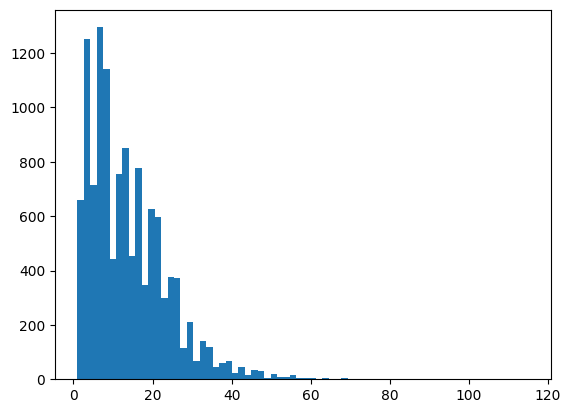

In [63]:
import matplotlib.pyplot as plt
plt.hist(np.array(node_nb), bins=70)

In [68]:
node_nb = np.array(node_nb)
node_nb.max()

115

(array([5.558e+03, 2.250e+03, 1.528e+03, 1.068e+03, 5.810e+02, 3.440e+02,
        2.240e+02, 1.420e+02, 9.300e+01, 6.700e+01, 4.200e+01, 3.700e+01,
        2.100e+01, 2.200e+01, 9.000e+00, 7.000e+00, 5.000e+00, 1.300e+01,
        4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([   0.  ,   70.52,  141.04,  211.56,  282.08,  352.6 ,  423.12,
         493.64,  564.16,  634.68,  705.2 ,  775.72,  846.24,  916.76,
         987.28, 1057.8 , 1128.32, 1198.84, 1269.36, 1339.88, 1410.4 ,
        1480.92, 1551.44, 1621.96, 1692.48, 1763.  , 1833.52, 1904.04,
        1974.56, 2045.08, 2115.6 , 2186.12, 2256.64, 2327.16, 2397.68,
        2468.2 , 2538

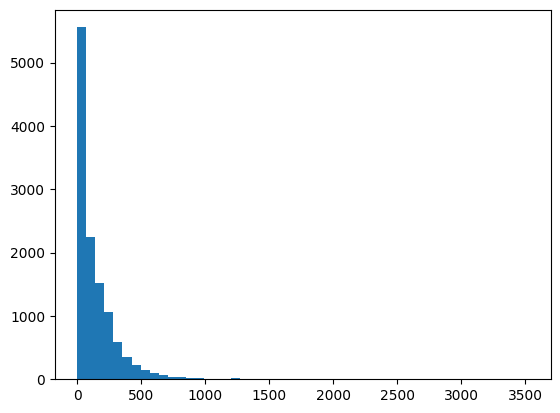

In [67]:
plt.hist(np.array(edge_nb), bins=50)

In [80]:
def balance_graphs(node_counts, edge_counts, nodes_per_group):
    # Calculate the total number of nodes and groups
    total_nodes = sum(node_counts)
    num_groups = total_nodes // nodes_per_group
    
    # Initialize groups
    groups = [[] for _ in range(num_groups)]
    
    # Create a list of (index, node_count, edge_count) tuples
    graphs = list(enumerate(zip(node_counts, edge_counts)))
    
    # Sort graphs in descending order of edge_counts
    sorted_graphs = sorted(graphs, key=lambda x: x[1][1], reverse=True)
    
    # Distribute graphs into groups
    for index, (nodes, edges) in sorted_graphs:
        for group in groups:
            if sum(graphs[i][1][0] for i in group) + nodes <= nodes_per_group:
                group.append(index)
                break
    
    return groups

# Example usage:
# node_counts = [10, 15, 8, 12, 7]  # List of node counts
# edge_counts = [20, 30, 25, 18, 14]  # List of edge counts
# num_groups = 2  # Set the number of groups



Group 0:
  Graph 6954 with 115 nodes and 3526 edges
  Graph 3556 with 13 nodes and 142 edges
  Total: 128 nodes and 3668 edges

Group 1:
  Graph 2769 with 70 nodes and 1910 edges
  Graph 3825 with 58 nodes and 1312 edges
  Total: 128 nodes and 3222 edges

Group 2:
  Graph 1939 with 92 nodes and 1774 edges
  Graph 3782 with 36 nodes and 772 edges
  Total: 128 nodes and 2546 edges

Group 3:
  Graph 10816 with 64 nodes and 1696 edges
  Graph 1926 with 62 nodes and 1372 edges
  Graph 23 with 2 nodes and 2 edges
  Total: 128 nodes and 3070 edges

Group 4:
  Graph 1776 with 67 nodes and 1688 edges
  Graph 10075 with 51 nodes and 1270 edges
  Graph 1385 with 10 nodes and 88 edges
  Total: 128 nodes and 3046 edges

Group 5:
  Graph 666 with 69 nodes and 1510 edges
  Graph 2217 with 59 nodes and 1264 edges
  Total: 128 nodes and 2774 edges

Group 6:
  Graph 10138 with 75 nodes and 1468 edges
  Graph 1405 with 51 nodes and 1258 edges
  Graph 53 with 2 nodes and 2 edges
  Total: 128 nodes and 272

In [129]:
import itertools

def balance_graphs(node_counts, edge_counts, nodes_per_group):
    num_groups = sum(node_counts) // nodes_per_group
    num_graphs = len(node_counts)

    # Calculate the total number of edges
    total_edges = sum(edge_counts)

    # Sort graphs by edge counts in ascending order
    sorted_graphs = sorted(enumerate(edge_counts), key=lambda x: x[1])

    # Initialize group assignments
    group_assignments = [-1] * num_graphs

    # Initialize group statistics
    group_node_sums = [0] * num_groups
    group_edge_sums = [0] * num_groups

    for graph_idx, edge_count in sorted_graphs:
        # Try to add the graph to the group with the smallest sum of nodes
        min_group = group_node_sums.index(min(group_node_sums))
        if group_assignments[graph_idx] == -1:
            if group_node_sums[min_group] + node_counts[graph_idx] <= nodes_per_group:
                group_assignments[graph_idx] = min_group
                group_node_sums[min_group] += node_counts[graph_idx]
                group_edge_sums[min_group] += edge_count

    # If there are unassigned graphs, assign them to the group with the smallest edge sum
    for graph_idx, edge_count in sorted_graphs:
        if group_assignments[graph_idx] == -1:
            min_group = group_edge_sums.index(min(group_edge_sums))
            group_assignments[graph_idx] = min_group
            group_edge_sums[min_group] += edge_count

    # Organize the groups
    groups = [[] for _ in range(num_groups)]
    for graph_idx, group_idx in enumerate(group_assignments):
        groups[group_idx].append(graph_idx)
    return groups



In [130]:
groups = balance_graphs(node_nb, edge_nb, 128)

for i, group in enumerate(groups):
    node_sum = 0
    edge_sum = 0
    print(f'Group {i}:')
    for index in group:
        nodes, edges = node_nb[index], edge_nb[index]
        node_sum += nodes
        edge_sum += edges
        print(f'  Graph {index + 1} with {nodes} nodes and {edges} edges')
    print(f'  Total: {node_sum} nodes and {edge_sum} edges\n')


[103, 126, 105, 117, 97, 103, 99, 108, 125, 106, 105, 102, 102, 114, 102, 128, 104, 127, 97, 104, 97, 103, 104, 99, 125, 128, 107, 127, 126, 98, 108, 121, 106, 128, 127, 118, 105, 112, 98, 100, 127, 97, 105, 102, 101, 103, 103, 105, 106, 104, 99, 111, 100, 100, 111, 101, 98, 104, 104, 106, 102, 122, 102, 103, 112, 104, 106, 104, 106, 108, 97, 105, 102, 102, 100, 106, 105, 102, 99, 97, 106, 127, 108, 98, 106, 101, 105, 105, 101, 104, 102, 110, 102, 100, 108, 103, 114, 104, 113, 99, 105, 102, 104, 100, 108, 103, 106, 124, 106, 107, 128, 103, 107, 99, 109, 107, 105, 111, 103, 100, 101, 111, 106, 106, 110, 100, 125, 106, 97, 99, 111, 112, 127, 113, 109, 110, 104, 101, 98, 109, 101, 117, 107, 113, 102, 110, 109, 103, 104, 98, 97, 104, 114, 103, 106, 105, 103, 112, 101, 101, 107, 108, 104, 108, 103, 103, 109, 100, 105, 106, 108, 128, 100, 116, 104, 107, 101, 110, 101, 110, 107, 105, 98, 103, 117, 128, 119, 105, 103, 110, 102, 113, 109, 100, 98, 102, 105, 102, 104, 102, 108, 106, 103, 100, 11

1304


In [104]:
from Dataset.Datamodule import CROHMEDatamodule
dm = CROHMEDatamodule(
    root_path = npz_path,
    shuffle = True,
    num_workers = 0,
    reload_dataloaders_every_n_epochs=1
)


{'root_path': '/home/e19b516g/yejing/data/data_for_graph/npz/train', 'shuffle': True, 'num_workers': 0, 'reload_dataloaders_every_n_epochs': 1}


In [110]:
list = ['N2E20_form_5_673_E3363', 'N5E29_form_5_673_E3363', 'N25E290_form_5_673_E3363']
# get number behind N and E in the list
import re
node_nb = []
edge_nb = []
for i in list:
    n = i.split('_')[0]
    node_nb.append(n.split('E')[0].split('N')[1])
    edge_nb.append(n.split('E')[1])

In [111]:
edge_nb

['20', '29', '290']

In [124]:
x_rand = torch.rand(3, 3, 4, 5)
xx = torch.zeros(0, 0, 4, 5)
xx = torch.cat((xx, x_rand), dim=2)

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 0 but got size 3 for tensor number 1 in the list.

In [3]:
import torch
g_ = torch.rand(3, 8, 64)
g_r = g_.repeat(3, 1, 1)
g_r_i = g_.repeat_interleave(3, dim=0)
print(g_r.shape)
print(g_r_i.shape)

torch.Size([9, 8, 64])
torch.Size([9, 8, 64])


In [13]:
b = torch.rand(9, 8, 32)

In [7]:
g_con = torch.cat([g_r, g_r_i], dim=-1)

In [15]:
torch.cat([g_r, g_r_i, b], dim=-1).shape

torch.Size([9, 8, 160])

In [36]:
import numpy as np
npz = np.load('/home/e19b516g/yejing/data/data_for_graph/S150_R10/train/N15E128_form_023_E178.npz')
print(npz['edge_labels'])

[[ 0.  2.  2.  0. 14. 14.  0. 14. 14. 14.  0.  0. 14.  0. 14.]
 [ 0.  0.  1.  0.  2. 14. 14. 14.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  2. 14. 14. 14.  0.  0.  0.  0. 14.  0.  0.]
 [ 0.  0.  0.  0. 11.  0. 23.  0. 23. 23.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  6.  2. 14.  0. 14.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.  2.  0. 14.  0.  0. 14.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  2.  0. 14. 14. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  2.  2.  0. 14.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  2. 14. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 11.  0. 23.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [43]:
los = npz['los']
el = npz['edge_labels']
los = torch.from_numpy(los)
el = torch.from_numpy(el)
los = torch.triu(los)
indices = torch.nonzero(los.reshape(-1))
el = el.reshape(-1)[indices]

In [46]:
len(indices)

64

In [47]:
los.shape

torch.Size([15, 15])

In [204]:
import torch
pt = torch.load('/home/e19b516g/yejing/code/Edge_GAT/val_results/S150_R10_2024_01_01_07_09_41/epoch_90.pt', map_location=torch.device('cpu'))

In [205]:
node_pred = torch.zeros(0)
edge_pred = torch.zeros(0)
node_label = torch.zeros(0)
edge_label = torch.zeros(0)
for i in pt:
    node_hat = torch.argmax(i[0], dim=1)
    node_pred = torch.cat((node_pred, node_hat), dim=0)
    stroke_label = i[1]
    node_label = torch.cat((node_label, stroke_label), dim=0)
    edge_hat = torch.argmax(i[2], dim=1)
    edge_pred = torch.cat((edge_pred, edge_hat), dim=0)
    rel_label = i[3]
    edge_label = torch.cat((edge_label, rel_label), dim=0)



In [206]:
from sklearn.metrics import accuracy_score
print(accuracy_score(node_label, node_pred))
print(accuracy_score(edge_label, edge_pred))


0.8599148130619971
0.8944904395821013


In [207]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(edge_label, edge_pred)
cm_node = confusion_matrix(node_label, node_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(26))
# disp.plot()


In [200]:
max(edge_label)

tensor(13.)

In [208]:
num_classes = cm_node.shape[0]
class_accuracies = {}
for i in range(num_classes):
    class_accuracies[f"Class_{i}"] = cm_node[i, i] / cm_node[i].sum()

# Print accuracy for each class
for key, value in class_accuracies.items():
    print(f"Accuracy for {key}: {value:.8f}")

Accuracy for Class_0: 0.00000000
Accuracy for Class_1: 0.95742574
Accuracy for Class_2: 0.95078979
Accuracy for Class_3: 0.92182802
Accuracy for Class_4: 0.97270115
Accuracy for Class_5: 0.88629944
Accuracy for Class_6: 0.94709772
Accuracy for Class_7: 0.96282974
Accuracy for Class_8: 0.97115385
Accuracy for Class_9: 0.92051756
Accuracy for Class_10: 0.94819820
Accuracy for Class_11: 0.90802348
Accuracy for Class_12: 0.96551724
Accuracy for Class_13: 0.87612613
Accuracy for Class_14: 0.94750656
Accuracy for Class_15: 0.87637363
Accuracy for Class_16: 0.94710327
Accuracy for Class_17: 0.90024331
Accuracy for Class_18: 0.85410334
Accuracy for Class_19: 0.89440994
Accuracy for Class_20: 0.82229965
Accuracy for Class_21: 0.91162791
Accuracy for Class_22: 0.74733096
Accuracy for Class_23: 0.77431907
Accuracy for Class_24: 0.83600000
Accuracy for Class_25: 0.78102190
Accuracy for Class_26: 0.76923077
Accuracy for Class_27: 0.82198953
Accuracy for Class_28: 0.89189189
Accuracy for Class_29: 0

In [209]:
num_classes = cm.shape[0]
class_accuracies = {}
for i in range(num_classes-1):
    class_accuracies[f"Class_{i}"] = cm[i, i] / cm[i].sum()

# Print accuracy for each class
for key, value in class_accuracies.items():
    print(f"Accuracy for {key}: {value:.8f}")

Accuracy for Class_0: 0.69034091
Accuracy for Class_1: 0.95140061
Accuracy for Class_2: 0.95541947
Accuracy for Class_3: 0.74003984
Accuracy for Class_4: 0.85744456
Accuracy for Class_5: 0.94067797
Accuracy for Class_6: 0.93030303
Accuracy for Class_7: 0.76450512
Accuracy for Class_8: 0.00000000
Accuracy for Class_9: 0.00000000
Accuracy for Class_10: 0.89491525
Accuracy for Class_11: 0.00000000


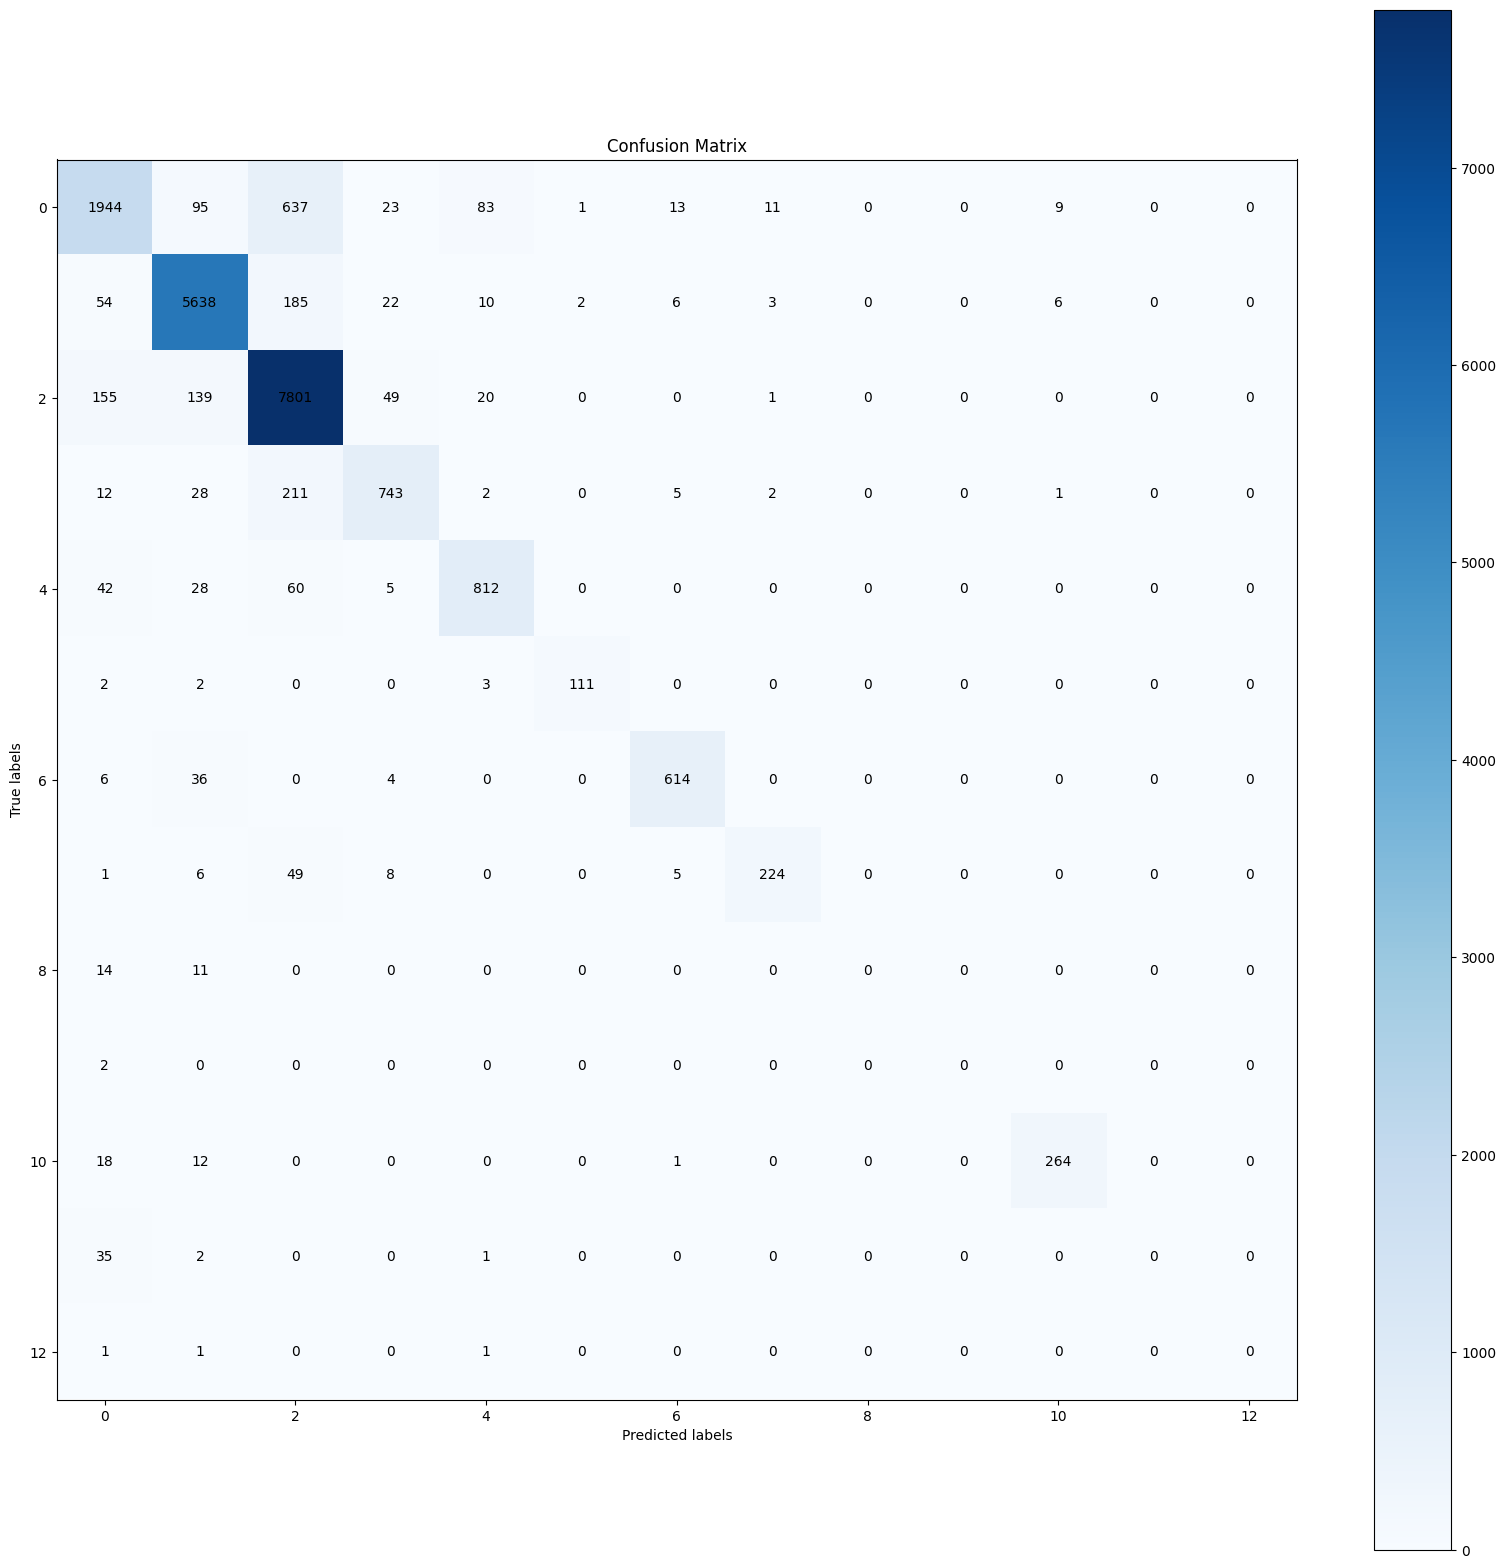

In [210]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))  # Change the figure size as needed

# Plot confusion matrix
plt.imshow(cm, cmap='Blues')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.colorbar()

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [79]:
acc = (edge_label == edge_pred).sum().item() / edge_label.shape[0]

In [80]:
acc

0.966819825833191

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(torch.argmax(pt[3][0], dim=1), pt[3][1])

0.5261044176706827

In [36]:
pt[0][3]

tensor([0, 2, 0,  ..., 9, 1, 0])

In [102]:
import numpy as np
npz = np.load('/home/e19b516g/yejing/data/data_for_graph/S100_R5_Speed_False/test/N9E54_form_5_237_E1183.npz')

In [103]:
edge_l = npz['edge_labels']

In [104]:
los = npz['los']

In [89]:
def find_path(adj_matrix, start, end, visited=None, path=None):
    if visited is None:
        visited = set()
    if path is None:
        path = []

    # Mark the current node as visited and add it to the path
    visited.add(start)
    path.append(start)

    # If the current node is the destination, return the path
    if start == end:
        return path

    # Check neighbors of the current node
    for node, connected in enumerate(adj_matrix[start]):
        if connected and node not in visited:
            # Recursively call find_path for unvisited neighbors
            new_path = find_path(adj_matrix, node, end, visited, path)
            if new_path:
                return new_path

    # If no path is found, backtrack
    path.pop()
    return None

In [108]:
def set_below_diagonal_to_zero(matrix):
    rows, cols = np.tril_indices(matrix.shape[0], k=-1)  # Get indices below the diagonal
    matrix[rows, cols] = 0  # Set elements below the diagonal to 0
    return matrix

In [116]:
new_edge_l = set_below_diagonal_to_zero(edge_l)
new_edge_l = np.where(new_edge_l == 1, 0, new_edge_l)

In [105]:
print(los)
print(edge_l)

[[0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [1. 1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 0. 1. 0. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0.]]
[[ 0.  1.  2.  2.  0.  0.  0.  0.  0.]
 [ 1.  0.  2.  2.  0.  0.  0.  0.  0.]
 [ 8.  8.  0.  1.  2.  2.  0.  0.  0.]
 [ 8.  8.  1.  0.  2.  2.  0.  0.  0.]
 [ 0.  0.  8.  8.  0.  1.  7.  0.  0.]
 [ 0.  0.  8.  8.  1.  0.  7.  0.  0.]
 [ 0.  0.  0.  0. 13. 13.  0.  6.  5.]
 [ 0.  0.  0.  0.  0.  0. 12.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 11.  0.  0.]]


In [118]:
for i in range(los.shape[0]):
    for j in range(i+1, los.shape[0]):
        if los[i][j] == 1 and edge_l[i][j] == 0:
            path = find_path(new_edge_l, i, j)
            print(i,j)
            print(path)
            if path is not None:
                new_edge_l[i][j] = edge_l[path[0]][path[1]]
                print(edge_l[path[0]][path[1]])

0 4
[0, 2, 4]
2.0
0 5
[0, 2, 5]
2.0
0 6
[0, 2, 4, 6]
2.0
0 7
[0, 2, 4, 6, 7]
2.0
0 8
[0, 2, 4, 6, 8]
2.0
1 4
[1, 2, 4]
2.0
1 5
[1, 2, 5]
2.0
1 6
[1, 2, 4, 6]
2.0
1 8
[1, 2, 4, 6, 8]
2.0
2 8
[2, 4, 6, 8]
2.0
3 8
[3, 4, 6, 8]
2.0
4 7
[4, 6, 7]
7.0
4 8
[4, 6, 8]
7.0
5 8
[5, 6, 8]
7.0
7 8
None


In [119]:
new_edge_l

array([[0., 0., 2., 2., 2., 2., 2., 2., 2.],
       [0., 0., 2., 2., 2., 2., 2., 0., 2.],
       [0., 0., 0., 0., 2., 2., 0., 0., 2.],
       [0., 0., 0., 0., 2., 2., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 7., 7., 7.],
       [0., 0., 0., 0., 0., 0., 7., 0., 7.],
       [0., 0., 0., 0., 0., 0., 0., 6., 5.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [120]:
los

array([[0., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 0., 1.],
       [0., 1., 0., 1., 1., 0., 0., 0., 1.],
       [1., 1., 1., 0., 1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 0., 0., 1., 0., 1., 0., 1.],
       [1., 1., 0., 0., 1., 1., 0., 1., 1.],
       [1., 0., 0., 0., 1., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0.]])

In [121]:
l = torch.tensor(los)

In [122]:
torch.triu(l)

tensor([[0., 1., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [8]:
import numpy as np
new_npz = np.load('/home/e19b516g/yejing/data/data_for_graph/S50_R5_equation/train/N10E60_form_5_769_E3845.npz')

In [9]:
new_npz['edge_labels']

array([[ 0.,  1.,  2.,  0.,  0., 14.,  0.,  0., 14.,  0.],
       [ 1.,  0.,  2., 14.,  0., 14.,  0., 14.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  2., 14.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  2., 14., 14., 14.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  2., 14., 14.,  0., 14.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  2., 14., 14.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2., 14.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2., 14.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [10]:
new_npz['los']

array([[0., 1., 1., 0., 0., 1., 0., 0., 1., 0.],
       [1., 0., 1., 1., 0., 1., 0., 1., 0., 0.],
       [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 1., 0., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 0., 1., 1., 1., 1., 0., 1., 1.],
       [1., 0., 0., 1., 0., 1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.]])

In [1]:
from Preprocessing.load import load_gt
inkml = '/home/e19b516g/yejing/data/data_for_graph/INKML/train/CROHME2023_train/form_002_E12.inkml'
lg = '/home/e19b516g/yejing/data/data_for_graph/LG/train/CROHME2023_train/form_002_E12.lg'
s, sl, el, los = load_gt(inkml, lg)

tensor([[0., 2., 2., 2.],
        [0., 0., 3., 3.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


In [48]:
los_b = torch.zeros(100, 100)
start = 0
los_b[start:start+los.shape[0], start:start+los.shape[0]] = los

In [64]:
label_b = torch.zeros(100, 100)
label_b[start:start+los.shape[0], start:start+los.shape[0]] = torch.tensor(npz['edge_labels'])

In [67]:
torch.set_printoptions(threshold=np.inf)
print(label_b)

tensor([[ 0.,  2.,  2.,  0., 14., 14.,  0., 14., 14., 14.,  0.,  0., 14.,  0.,
         14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  1.,  0.,  2., 14., 14., 14.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.

In [54]:
print(los_b.shape)

torch.Size([100, 100])


In [104]:
import os
import numpy as np
for _, _, files in os.walk('/home/e19b516g/yejing/data/data_for_graph/S150_R10/train'):
    for file in files:
        if file.endswith('.npz'):
            npz = np.load(os.path.join('/home/e19b516g/yejing/data/data_for_graph/S150_R10/train', file))
            label = npz['edge_labels']
            print(label.max())

26.0
27.0
24.0
28.0
26.0
20.0
21.0
27.0
21.0
25.0
26.0
26.0
20.0
25.0
20.0
30.0
20.0
26.0
35.0
24.0
20.0
20.0
25.0
21.0
20.0
21.0
20.0
20.0
26.0
1.0
9.0
20.0
28.0
20.0
22.0
30.0
28.0
26.0
26.0
27.0
0.0
21.0
20.0
23.0
25.0
14.0
35.0
26.0
21.0
30.0
25.0
26.0
34.0
27.0
21.0
20.0
27.0
20.0
26.0
26.0
22.0
26.0
35.0
20.0
26.0
27.0
21.0
20.0
12.0
20.0
20.0
14.0
22.0
22.0
21.0
14.0
22.0
30.0
26.0
20.0
26.0
20.0
35.0
25.0
24.0
25.0
24.0
20.0
27.0
21.0
24.0
26.0
24.0
26.0
20.0
25.0
27.0
27.0
20.0
35.0
16.0
22.0
24.0
25.0
26.0
35.0
0.0
30.0
20.0
21.0
26.0
8.0
22.0
27.0
27.0
21.0
20.0
14.0
0.0
24.0
26.0
22.0
26.0
24.0
28.0
28.0
26.0
25.0
36.0
25.0
20.0
22.0
25.0
14.0
26.0
25.0
22.0
30.0
22.0
22.0
30.0
24.0
30.0
25.0
26.0
20.0
0.0
20.0
30.0
22.0
20.0
24.0
32.0
26.0
34.0
20.0
20.0
35.0
27.0
20.0
20.0
20.0
26.0
24.0
14.0
20.0
21.0
26.0
25.0
20.0
27.0
28.0
25.0
22.0
27.0
31.0
26.0
26.0
8.0
26.0
20.0
20.0
25.0
26.0
26.0
22.0
20.0
0.0
30.0
20.0
24.0
30.0
26.0
26.0
1.0
31.0
30.0
28.0
21.0
20.0
22.0
31.0


In [118]:
from Dataset.Dataset import CROHMEDataset
ds = CROHMEDataset(
    data_type='train',
    root_path='/home/e19b516g/yejing/data/data_for_graph/S100_R10',
    batch_size=128,
    max_node=-1
    )

In [73]:
def edge_filter(edges_emb, edges_label, los):
    los = los.squeeze().fill_diagonal_(0)
    los = torch.triu(los)
    indices = torch.nonzero(los.reshape(-1)).squeeze()
    edges_label = edges_label[indices]
    edges_emb = edges_emb.reshape(-1, edges_emb.shape[-1])[indices]
    return edges_emb, edges_label

In [120]:
# strokes, relations, los, s_label, r_label = ds.__getitem__(20)
for i in range(ds.__len__()):
    strokes, relations, los, s_label, r_label = ds.__getitem__(i)
    _, new_edge_l = edge_filter(relations, r_label.reshape(-1), los)
    print(torch.where(new_edge_l == 0, 1, 0).sum())
    # calculate number of 0 in new_edge_l

[22, 235, 1262, 2148, 2765, 3901, 3909, 4192, 4460]
tensor(79)
[67, 351, 532, 2228, 4070, 4219, 4278, 5211, 5935, 6147]
tensor(217)
[83, 176, 253, 394, 1340, 2216, 2449, 4128, 4336, 4533]
tensor(241)
[80, 104, 2651, 2811, 4055, 4121, 4339, 4469, 6068]
tensor(61)
[128, 379, 709, 2760, 4347, 4406, 4532, 4900, 5327, 5368]
tensor(372)
[154, 173, 729, 981, 1420, 2654, 2788, 3671, 4360]
tensor(216)
[230, 841, 1064, 1495, 2807, 3176, 3833, 4362, 4599, 5320]
tensor(163)
[68, 277, 1018, 2801, 2859, 4466, 4524, 4775, 5599, 6163]
tensor(480)
[417, 857, 1931, 1992, 2904, 4568, 4730, 5352, 5655, 5803]
tensor(134)
[344, 443, 634, 1149, 1199, 1965, 2932, 4602, 5213, 5419]
tensor(111)
[493, 1188, 1487, 2059, 2943, 3127, 4801, 4857, 5511, 5659]
tensor(157)
[352, 558, 676, 1204, 2155, 3275, 4733, 4806, 4925, 5209]
tensor(76)
[9, 238, 462, 604, 1084, 1509, 1645, 3356, 4853]
tensor(123)
[414, 665, 761, 1218, 1559, 1792, 3495, 4788, 4856, 5448]
tensor(84)
[606, 746, 766, 959, 1498, 2952, 3567, 3584, 4586, 

In [4]:
import os
import numpy as np
import torch
npz_path = '/home/e19b516g/yejing/data/data_for_graph/S100_R10/train/'
for _, _, files in os.walk(npz_path):
    for file in files:
        if file.endswith('.npz'):
            print(file)
            npz = np.load(os.path.join(npz_path, file))
            new_los = torch.triu(torch.tensor(npz['los']))
            indices = torch.nonzero(new_los.reshape(-1)).squeeze()
            label = torch.tensor(npz['edge_labels']).reshape(-1)
            new_label = label[indices]
            print(new_label.max())
            print(torch.where(new_label == 0, 1, 0).sum())

N7E34_form_5_663_E3311.npz
tensor(14.)
tensor(4)
N7E34_form_5_718_E3590.npz
tensor(14.)
tensor(0)
N8E38_form_016_E126.npz
tensor(16.)
tensor(0)
N9E52_form_5_725_E3622.npz
tensor(14.)
tensor(0)
N9E54_form_5_687_E3433.npz
tensor(14.)
tensor(13)
N4E12_form_5_185_E924.npz
tensor(14.)
tensor(0)
N7E28_form_042_E330.npz
tensor(19.)
tensor(5)
N6E28_form_021_E161.npz
tensor(14.)
tensor(0)
N5E20_form_5_710_E3548.npz
tensor(14.)
tensor(0)
N4E12_form_5_716_E3579.npz
tensor(14.)
tensor(0)
N7E30_form_5_664_E3319.npz
tensor(14.)
tensor(0)
N4E10_form_5_714_E3567.npz
tensor(19.)
tensor(0)
N8E30_form_022_E175.npz
tensor(14.)
tensor(8)
N9E56_form_020_E158.npz
tensor(14.)
tensor(0)
N4E8_form_5_667_E3335.npz
tensor(11.)
tensor(0)
N9E50_form_008_E61.npz
tensor(19.)
tensor(0)
N6E24_form_5_709_E3543.npz
tensor(14.)
tensor(0)
N10E72_form_087_E693.npz
tensor(14.)
tensor(0)
N3E4_form_5_797_E3983.npz
tensor(6.)
tensor(0)
N6E26_form_5_201_E1002.npz
tensor(14.)
tensor(0)
N10E64_form_5_184_E920.npz
tensor(14.)
tenso

In [127]:
p = os.path.join(npz_path, 'N8E56_formulaire028-equation062.npz')
npz_p = np.load(p)

In [128]:
npz_p['edge_labels']

array([[ 0.,  3.,  3., 15., 15.,  2.,  2., 14.],
       [ 0.,  0.,  1.,  2.,  2.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  2.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [129]:
npz_p['los']

array([[0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0.]])

In [7]:
import torch
x = torch.rand(3,100)
x_re = x.repeat(1, 3).reshape(3, 3, 100)

In [8]:
x_n = x_re.fill_diagonal_(0)

RuntimeError: all dimensions of input must be of equal length

In [99]:
t1 = torch.rand(5, 3, 3)
t2 = t1 * (1-torch.eye(3, 3).repeat(5, 1, 1))

In [101]:
t = torch.zeros(5, 3, 3)
t + torch.eye(3, 3).repeat(5, 1, 1)

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])

In [107]:
# tensor 3*4, the value of the first column is 1, the value of the second column is 2, and so on
test = torch.arange(1, 5).repeat(3, 1).T
test[0]

tensor([1, 1, 1])

In [108]:
new_los = torch.zeros(128, 128)
los = torch.rand(16, 8, 8)
for i in range(los.shape[0]):
    new_los[i*los.shape[1]:(i+1)*los.shape[1], i*los.shape[1]:(i+1)*los.shape[1]] = los[i]

In [114]:
new_los[5:14, 5:14]

tensor([[0.4634, 0.8891, 0.7995, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1779, 0.2101, 0.7915, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4677, 0.9473, 0.2714, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5434, 0.2909, 0.8407, 0.2616, 0.6924, 0.9898],
        [0.0000, 0.0000, 0.0000, 0.8704, 0.8633, 0.2672, 0.7429, 0.7498, 0.7292],
        [0.0000, 0.0000, 0.0000, 0.8728, 0.6092, 0.2469, 0.0692, 0.5026, 0.3451],
        [0.0000, 0.0000, 0.0000, 0.4610, 0.9577, 0.7567, 0.6225, 0.7128, 0.4874],
        [0.0000, 0.0000, 0.0000, 0.8252, 0.2034, 0.8150, 0.3074, 0.3537, 0.7617],
        [0.0000, 0.0000, 0.0000, 0.4938, 0.4143, 0.8133, 0.5339, 0.1139, 0.7351]])

In [109]:

indices = torch.arange(16) * 8
new_los[indices[:, None], indices] = los.view(-1, 8, 8)

RuntimeError: shape mismatch: value tensor of shape [16, 8, 8] cannot be broadcast to indexing result of shape [16, 16]

In [28]:
t = torch.rand(3, 3, 5)
print(t)
torch.diagonal(t).transpose(0, 1)

tensor([[[0.0972, 0.5388, 0.4293, 0.3251, 0.0872],
         [0.4141, 0.7195, 0.2112, 0.6444, 0.6719],
         [0.3511, 0.1460, 0.3298, 0.2380, 0.6604]],

        [[0.2852, 0.4086, 0.8565, 0.1639, 0.4146],
         [0.0221, 0.3061, 0.2775, 0.3543, 0.7437],
         [0.5826, 0.0664, 0.3610, 0.8034, 0.6237]],

        [[0.5303, 0.3247, 0.0189, 0.7181, 0.2565],
         [0.0674, 0.3828, 0.1951, 0.3126, 0.1731],
         [0.2015, 0.5238, 0.5766, 0.0561, 0.7050]]])


tensor([[0.0972, 0.5388, 0.4293, 0.3251, 0.0872],
        [0.0221, 0.3061, 0.2775, 0.3543, 0.7437],
        [0.2015, 0.5238, 0.5766, 0.0561, 0.7050]])

In [30]:
def calculate_piece_positions(shape, padding_size):
    total_length = shape
    start = 0
    positions = []
    
    while start < total_length:
        end = min(start + 8, total_length)
        positions.append([start, end])
        start = end
    
    if padding_size > 0:
        positions[0][0] -= padding_size  # Adjust the start position for the first piece
        
        # Adjust the end position for the last piece if there's padding
        last_piece_index = len(positions) - 1
        positions[last_piece_index][1] += padding_size
        
        # Adjust the end position of the last piece if it exceeds the total length
        if positions[last_piece_index][1] > total_length:
            positions[last_piece_index][1] = total_length
    
    return positions

In [76]:
def padding(name, shape, pad):
    list = []
    list.append([name, shape, 0, 8 - pad])
    start = 8 - pad
    nb = math.ceil((shape + pad) / 8)
    for i in range(nb - 1):
        if i == nb - 2:
            end = shape
        else:
            end = start + 8
        list.append([name, shape, start, end])
        start += 8
    return list

In [79]:
import math
padding('miaom',80, 5)

[['miaom', 80, 0, 3],
 ['miaom', 80, 3, 11],
 ['miaom', 80, 11, 19],
 ['miaom', 80, 19, 27],
 ['miaom', 80, 27, 35],
 ['miaom', 80, 35, 43],
 ['miaom', 80, 43, 51],
 ['miaom', 80, 51, 59],
 ['miaom', 80, 59, 67],
 ['miaom', 80, 67, 75],
 ['miaom', 80, 75, 80]]

In [93]:
t = torch.rand(10, 10)
t[8:10,:].shape

torch.Size([2, 10])

In [83]:
import numpy as np
npz = np.load('/home/e19b516g/yejing/data/data_for_graph/S100_R10/test/N10E42_form_315_E2513.npz')

In [95]:
torch.from_numpy(npz['edges_emb']).shape

torch.Size([10, 10, 4, 10])

In [130]:
def load_batch(batch):
    strokes_emb, edges_emb, los, strokes_label, edges_label = batch
    strokes_emb = strokes_emb
    strokes_emb = strokes_emb.reshape(strokes_emb.shape[0]*strokes_emb.shape[1], strokes_emb.shape[2], strokes_emb.shape[3])
    edges_emb = edges_emb.squeeze(0).reshape(edges_emb.shape[0],edges_emb.shape[1], edges_emb.shape[2], edges_emb.shape[3]* edges_emb.shape[4])
    strokes_label = strokes_label.squeeze(0).long().reshape(-1)
    edges_label = edges_label.squeeze(0).long()
    # los = los.squeeze(0).fill_diagonal_(1).unsqueeze(-1)
    los = los + torch.eye(los.shape[1], los.shape[2]).repeat(los.shape[0], 1, 1)
    new_los = torch.zeros((los.shape[0]*los.shape[1], los.shape[0]*los.shape[2]))
    new_edges_label = torch.zeros((edges_label.shape[0]*edges_label.shape[1], edges_label.shape[0]*edges_label.shape[2])).long()
    new_edges_emb = torch.zeros((edges_emb.shape[0]*edges_emb.shape[1], edges_emb.shape[0]*edges_emb.shape[2], edges_emb.shape[3]))
    for i in range(los.shape[0]):
        new_los[i*los.shape[1]:(i+1)*los.shape[1], i*los.shape[1]:(i+1)*los.shape[1]] = los[i]
        new_edges_label[i*edges_label.shape[1]:(i+1)*edges_label.shape[1], i*edges_label.shape[1]:(i+1)*edges_label.shape[1]] = edges_label[i]
        new_edges_emb[i*edges_emb.shape[1]:(i+1)*edges_emb.shape[1], i*edges_emb.shape[1]:(i+1)*edges_emb.shape[1]] = edges_emb[i]
    return strokes_emb, new_edges_emb, new_los.unsqueeze(-1), strokes_label, new_edges_label.reshape(-1)

In [132]:
from Dataset.Datamodule import CROHMEDatamodule
dm = CROHMEDatamodule(
    root_path = '/home/e19b516g/yejing/data/data_for_graph/S100_R10',
    shuffle = True,
    num_workers = 0,
    batch_size = 8,
    max_node = 8,
    reload_dataloaders_every_n_epochs=1
)
dm.setup('fit')
for batch in dm.train_dataloader():
    try:
        r = load_batch(batch)
    except:
        print('error')
        print(batch[0].shape)

random_padding_size:  0


In [146]:
import numpy as np
import matplotlib.pyplot as plt
npy = np.load('/home/e19b516g/yejing/data/data_for_graph/S150_R10/train/N15E128_form_023_E178.npz')

In [147]:
strokes_emb = npy['strokes_emb']
print(strokes_emb.shape)

(15, 150, 2)


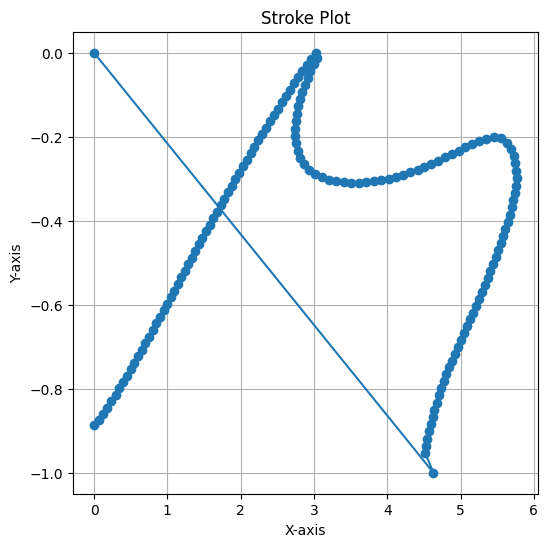

In [149]:
stroke = strokes_emb[0]
plt.figure(figsize=(6, 6))
plt.plot(stroke[:, 0], -stroke[:, 1], marker='o', linestyle='-')
plt.title('Stroke Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [170]:
import torch
t = torch.rand(3, 3, 5).long()


In [174]:
tt = torch.where(t == 0, 1, 0)

In [156]:
data = torch.rand(8, 3, 3, 10)
mean = data.mean(dim=(0,1,2), keepdim=True)
std = data.std(dim=(0,1, 2), keepdim=True)

In [157]:
print(data.shape)
print(mean.shape)
print(std.shape)

torch.Size([8, 3, 3, 10])
torch.Size([1, 1, 1, 10])
torch.Size([1, 1, 1, 10])


In [81]:
print(((data- mean)/std).shape)

torch.Size([3, 3, 4, 10])


In [86]:
los = torch.eye(3, 3)
am = torch.ones(3, 3)
print(am  los)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [135]:
import numpy as np

def calculate_curvature(stroke):
    # Check for minimum number of points required for curvature calculation
    if len(stroke) < 3:
        raise ValueError("At least three points are required for curvature calculation")

    # Convert the list of points to numpy array for easy calculations
    stroke = np.array(stroke)

    # Calculate first derivatives
    dx = np.gradient(stroke[:, 0])
    dy = np.gradient(stroke[:, 1])

    # Calculate second derivatives
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    # Calculate curvature using the formula: curvature = |dx * ddy - dy * ddx| / (dx^2 + dy^2)^(3/2)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**(3/2)

    return curvature

# Example stroke (list of points)
stroke = [(1, 5), (3, 2), (5, 6), (7, 8), (9, 10)]

# Calculate curvature for the stroke
curvatures = calculate_curvature(stroke)

print("Curvatures at each point:")
print(curvatures)


Curvatures at each point:
[0.14934236 0.68480647 0.03200193 0.04419417 0.        ]


In [147]:
strokes_emb = np.load('/home/e19b516g/yejing/data/data_for_graph/S100geo_feat/val/strokes_emb/N4E10_form_080_E638.npy')
print(strokes_emb.shape)

(4, 100, 2)


In [164]:
import os
src_path = '/home/e19b516g/yejing/data/data_for_graph/S150_R10/'
tgt_path = '/home/e19b516g/yejing/data/data_for_graph/S150_R10_new/'
for root, dirs, files in os.walk(src_path):
    for file in files:
        if file.endswith('.npz'):
            tag = root.split('/')[-1]
            file_name = file.split('.')[0]
            data = np.load(os.path.join(root, file))
            if not os.path.exists(os.path.join(tgt_path, tag, 'strokes_emb')):
                os.makedirs(os.path.join(tgt_path, tag, 'strokes_emb'))
            np.save(os.path.join(tgt_path, tag, 'strokes_emb', file_name), data['strokes_emb'])
            if not os.path.exists(os.path.join(tgt_path, tag, 'edges_emb')):
                os.makedirs(os.path.join(tgt_path, tag, 'edges_emb'))
            np.save(os.path.join(tgt_path, tag, 'edges_emb', file_name), data['edges_emb'])
            if not os.path.exists(os.path.join(tgt_path, tag, 'los')):
                os.makedirs(os.path.join(tgt_path, tag, 'los'))
            np.save(os.path.join(tgt_path, tag, 'los', file_name), data['los'])
            if not os.path.exists(os.path.join(tgt_path, tag, 'stroke_labels')):
                os.makedirs(os.path.join(tgt_path, tag, 'stroke_labels'))
            np.save(os.path.join(tgt_path, tag, 'stroke_labels', file_name), data['stroke_labels'])
            if not os.path.exists(os.path.join(tgt_path, tag, 'edge_labels')):
                os.makedirs(os.path.join(tgt_path, tag, 'edge_labels'))
            np.save(os.path.join(tgt_path, tag, 'edge_labels', file_name), data['edge_labels'])


In [193]:
from Preprocessing.LG.lg import Lg
lg = Lg('/home/e19b516g/yejing/data/data_for_graph/LG/val/CROHME2023_val/form_5_648_E3236.lg').segmentGraph()

In [216]:
lg_root_path = '/home/e19b516g/yejing/data/data_for_graph/LG/'
symbol_list = []
for root, dirs, files in os.walk(lg_root_path):
    for file in files:
        if file.endswith('.lg'):
            lg = Lg(os.path.join(root, file)).segmentGraph()
            for key in lg[0]:
                symbol_list.append(lg[0][key][1][0])

 !! Invalid object id: "+_1" - IGNORING relationship:
	['R', ' +_1', ' i_1', ' Right', ' 1.0']
 !! Invalid object id: "i_1" - IGNORING relationship:
	['R', ' +_1', ' i_1', ' Right', ' 1.0']
 !! Invalid object id: "=_1" - IGNORING relationship:
	['R', ' =_1', ' p_1', ' Right', ' 1.0']
 !! Invalid object id: "p_1" - IGNORING relationship:
	['R', ' =_1', ' p_1', ' Right', ' 1.0']
 !! Invalid object id: "H_1" - IGNORING relationship:
	['R', ' H_1', ' =_1', ' Right', ' 1.0']
 !! Invalid object id: "=_1" - IGNORING relationship:
	['R', ' H_1', ' =_1', ' Right', ' 1.0']
 !! Invalid object id: "i_1" - IGNORING relationship:
	['R', ' i_1', ' sin_1', ' Right', ' 1.0']
 !! Invalid object id: "sin_1" - IGNORING relationship:
	['R', ' i_1', ' sin_1', ' Right', ' 1.0']
 !! Invalid object id: "p_1" - IGNORING relationship:
	['R', ' p_1', ' +_1', ' Right', ' 1.0']
 !! Invalid object id: "+_1" - IGNORING relationship:
	['R', ' p_1', ' +_1', ' Right', ' 1.0']
 !! Invalid object id: "p_1" - IGNORING rela

In [197]:
print(symbol_list)

['3', '-', '2', '-', 'u', 'v', 't', 'n', '+', '+', 't', '2', '+', 'v', '-', '0', '+', '=', 'u', '\\cos', '6', '\\theta', '2', '-', '+', '+', 'h', 'h', 'h', '-', 'q', '1', '\\alpha', '3', '1', '=', '2', '\\sqrt', 'z', '4', 'q', 'x', 'p', 'a', 'b', 'L', 'b', 'a', '=', '-', 'x', 'p', 'a', 'b', '-', 'x', 'z', 'z', 'n', 't', '\\infty', 'n', '\\sum', '0', 'n', '=', 'b', 'a', 'a', '=', 'r', 'x', '\\sqrt', 'x', 'b', 'b', 'x', ')', 'a', 'x', '(', 'x', 'a', '=', '\\alpha', 'f', '(', '-', 'n', '4', ')', '(', '\\times', 'n', '4', ')', '-', '7', '2', '7', '-', '+', '-', '2', '1', 'p', '4', 'N', '-', '+', '2', '-', 'x', ')', 'i', '(', 'j', 'y', '+', '+', '\\rightarrow', 'y', 'w', 'y', 'y', '2', 'z', 'x', '\\pi', '=', 'i', '+', 'b', 'x', 'b', 'x', 'x', 'x', 'b', 'x', '2', 'd', '3', '+', '1', '+', '3', 'x', '1', '3', '1', '=', '2', 'A', 'd', '2', 'd', '\\int', 'd', '2', 'a', '8', 'b', '\\pi', 't', '2', '2', '.', '3', '7', '-', '\\times', '1', '9', '0', '6', '+', 'n', '3', '3', '-', 'j', ']', ')', '\\s

In [219]:
from collections import Counter
occurrences = Counter(symbol_list).most_common()
lg_dic = []
for xxx in occurrences:
    lg_dic.append(xxx[0])
# Print occurrences of each string
# for string, count in occurrences.items():
#     print(f"'{string}' occurs {count} times")


In [225]:
set(lg_dic) -set(ink_dic)

{'COMMA'}

In [209]:
import xml.etree.ElementTree as ET
doc_namespace = "{http://www.w3.org/2003/InkML}"
def load_inkml(file_path):
    strokes = []
    labels = []
    tree = ET.parse(file_path)
    root = tree.getroot()
    last_stroke = []
    dic = {}
    for trace_tag in root.findall(doc_namespace + 'traceGroup'):
        for trace_tag in trace_tag.findall(doc_namespace + 'traceGroup'):
            for annotation in trace_tag.findall(doc_namespace + 'annotation'):
                label = annotation.text
            for traceview in trace_tag.findall(doc_namespace + 'traceView'):
                s_id = traceview.get('traceDataRef')
                dic[s_id] = label
    for trace_tag in root.findall(doc_namespace + 'trace'):
        points = []
        last_point = (0, 0)
        for coord in (trace_tag.text).replace('\n', '').split(','):
            this_point = (float(coord.strip().split(' ')[0]), float(coord.strip().split(' ')[1]))
            if this_point != last_point:
                points.append(this_point)
                last_point = this_point
        for coord in trace_tag.items():
            id = coord[1]
        if last_stroke != points:
            strokes.append(points)
            points_np = np.array(points)
            if np.isnan(points_np).any() == True:
                print(file_path)
            if dic.__contains__(id):
                labels.append(dic[id])
            else:
                labels.append('None')
                dic[id] = 'None'
        last_stroke = points
    return labels

In [211]:
inkml_root_path = '/home/e19b516g/yejing/data/data_for_graph/INKML/'
symbol_list_ink = []
for root, dirs, files in os.walk(inkml_root_path):
    for file in files:
        if file.endswith('.inkml'):
            labels = load_inkml(os.path.join(root, file))
            symbol_list_ink = symbol_list_ink + labels

In [226]:
occurrences = Counter(symbol_list_ink).most_common()
ink_dic = []
for xxx in occurrences:
    print(xxx[0])
    ink_dic.append(xxx[0])

('+', 21329)
('x', 18376)
('-', 15849)
('=', 15099)
('1', 13296)
('2', 12875)
('(', 8343)
(')', 8332)
('4', 5568)
('\\sin', 5483)
('a', 5196)
('3', 4910)
('n', 4738)
('y', 4027)
('i', 3921)
('0', 3775)
('\\sqrt', 3724)
('5', 3420)
('b', 3391)
('z', 3054)
('\\cos', 2998)
('\\pi', 2937)
('t', 2784)
('7', 2730)
('d', 2567)
('\\times', 2320)
('k', 2278)
('f', 2202)
('c', 1850)
('\\lim', 1836)
('\\sum', 1801)
('\\theta', 1715)
('\\tan', 1683)
('p', 1658)
('6', 1636)
('9', 1545)
('8', 1486)
('\\log', 1433)
(',', 1431)
('A', 1389)
('\\rightarrow', 1265)
('j', 1251)
('\\ldots', 1204)
('X', 1178)
('\\int', 1095)
('e', 1059)
('.', 1046)
('E', 1024)
('\\leq', 1002)
('m', 994)
('|', 977)
('r', 977)
('F', 974)
('\\pm', 934)
('\\alpha', 892)
('B', 820)
('\\infty', 795)
('q', 776)
('\\beta', 747)
('\\neq', 710)
('[', 709)
('g', 659)
('u', 659)
('R', 657)
('\\div', 641)
('\\geq', 630)
('H', 624)
('v', 607)
('C', 552)
(']', 533)
('h', 526)
('T', 500)
('Y', 470)
('s', 463)
('N', 455)
('P', 444)
('I', 44

In [224]:
print(ink_dic)

['+', 'x', '-', '=', '1', '2', '(', ')', '4', '\\sin', 'a', '3', 'n', 'y', 'i', '0', '\\sqrt', '5', 'b', 'z', '\\cos', '\\pi', 't', '7', 'd', '\\times', 'k', 'f', 'c', '\\lim', '\\sum', '\\theta', '\\tan', 'p', '6', '9', '8', '\\log', ',', 'A', '\\rightarrow', 'j', '\\ldots', 'X', '\\int', 'e', '.', 'E', '\\leq', 'm', '|', 'r', 'F', '\\pm', '\\alpha', 'B', '\\infty', 'q', '\\beta', '\\neq', '[', 'g', 'u', 'R', '\\div', '\\geq', 'H', 'v', 'C', ']', 'h', 'T', 'Y', 's', 'N', 'P', 'I', '!', '/', '\\phi', 'M', 'L', 'w', 'S', 'V', 'G', 'l', '\\lt', '\\prime', '\\gamma', 'o', 'None', '\\mu', '\\}', '\\{', '\\Delta', '\\lambda', '\\gt', '\\sigma', '\\in', '\\forall', '\\exists', '<', '>']


In [1]:
import torch
tt = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
tt +1

tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

In [182]:
def get_mask(edge_labels, start, end):
    mask = torch.ones(end - start)
    max_len = edge_labels.shape[0]
    for i in range(end , start, -1):
        if i == max_len:
            break
        elif (edge_labels[i-1, i] == 1):
            pos = i - start - 1
            mask[pos] = 0
        else:
            break
    for i in range(start, end-1):
        if (edge_labels[i-1, i] == 1):
            pos = i - start
            mask[pos] = 0
        else:
            break
    return mask



In [122]:
import torch
edge_labels = torch.tensor([[0, 1, 0, 0, 0, 0, 0, 0],[1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1],[0, 0, 0, 0, 0, 0, 1, 0]])
max_node = 5
start = 0
end = 3

In [191]:
get_mask(edge_labels, 1, 5)

5


tensor([0., 1., 1., 1.])

In [137]:
edge_labels

tensor([[0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0]])

In [176]:
for i in range(8, 0, -1):
    print(i)

8
7
6
5
4
3
2
1


In [161]:
result_path = './results/test/N26E478_ISICal19_1210_em_880.pt'
import torch
pt = torch.load(result_path, map_location=torch.device('cpu'))
stroke_emb = pt[0]
edge_emb = pt[1]
stroke_label = pt[2]
edge_label = pt[3]


In [165]:
print(torch.argmax(edge_emb, dim=2) - edge_label)
# print(edge_label)

tensor([[0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 

In [163]:
print(torch.argmax(stroke_emb, dim=1))
print(stroke_label)

tensor([ 7, 28, 28,  1,  1, 62,  8,  7,  2,  2,  8,  4,  4,  4,  4,  7,  2,  2,
         8,  1,  1, 62,  7,  2,  2,  8])
tensor([ 7, 28, 28,  1,  1, 62,  8,  7,  2,  2,  8,  4,  4, 28, 28,  7,  2,  2,
         8,  1,  1, 62,  7,  2,  2,  8])


In [141]:
stroke_emb[-1]

tensor([5.1566e-11, 6.0696e-07, 1.0658e-07, 1.4816e-06, 3.4053e-07, 5.4544e-07,
        1.2017e-06, 4.3960e-07, 2.6475e-07, 9.9580e-08, 1.2609e-07, 2.3779e-05,
        2.6828e-07, 2.5148e-08, 8.4375e-07, 2.9923e-07, 2.0311e-07, 1.4003e-06,
        7.9012e-07, 9.9986e-01, 1.2296e-08, 1.4829e-07, 1.1265e-08, 1.3490e-06,
        9.3135e-08, 1.9791e-08, 3.2203e-07, 1.7520e-05, 1.8644e-08, 1.1735e-07,
        4.2368e-07, 4.3716e-08, 5.4434e-08, 5.8437e-10, 7.8882e-07, 3.7703e-07,
        9.6099e-08, 6.8436e-08, 1.0432e-07, 2.7366e-08, 1.8822e-08, 4.1890e-07,
        1.2999e-08, 3.0024e-08, 4.9913e-11, 1.0075e-07, 1.7464e-06, 2.3714e-07,
        6.5792e-05, 1.4435e-07, 1.2447e-10, 5.4033e-09, 1.2546e-07, 7.8514e-08,
        3.1152e-07, 2.1433e-08, 6.5892e-11, 5.7727e-09, 5.0930e-09, 2.8233e-09,
        1.2919e-10, 1.3222e-10, 8.6387e-08, 4.9738e-11, 6.6357e-10, 8.3697e-11,
        3.1928e-09, 5.6940e-11, 3.1843e-09, 4.5511e-11, 1.3805e-10, 1.5646e-05,
        3.3360e-10, 5.2527e-11, 2.5868e-

In [148]:
edge_emb[0,1]

tensor([7.5345e-01, 1.6274e-04, 2.0985e-04, 1.1362e-07, 5.4114e-07, 2.0564e-08,
        2.4616e-01, 4.3677e-08, 2.3808e-06, 7.4364e-09, 1.4717e-08, 4.4865e-06,
        1.7227e-06, 1.6277e-08])